In [1]:

import pandas
import numpy as np
def readAllDataOneHeuristic(path):
    dfWorse = pandas.read_table(path, delim_whitespace=True, names=('treeName', 'makespan', '#trees', 
                                                               'time0step', 'time1cut', 'timepartition', 
                                                                'timeassign','makespan1', '#trees1')
                       ,dtype={'treeName': str, 'makespan': np.float64, '#trees': np.float64, 
                                                               'time0step': np.float64, 'time1cut': np.float64,
                               'timepartition': np.float64,  'timeassign': np.float64, 'trees1': np.float64})
    
    dfWorse = dfWorse[pandas.notna(dfWorse['makespan'])]

    del dfWorse['#trees1']
    del dfWorse['makespan1']



    dfWorse['timeassign-'] = dfWorse['timeassign'].apply(lambda x: x*-1)
    columns_list = ['timepartition', 'timeassign-']

    dfWorse['timepartitionclean'] = dfWorse[columns_list].sum(axis=1)
    return dfWorse


def readAllDataOneHeuristicPure(path):
    dfWorse = pandas.read_table(path, delim_whitespace=True, names=('treeName', 'makespan', '#trees', 
                                                               'time0step', 'time1cut', 'timepartition', 
                                                                'timeassign','makespan1', '#trees1')
                       ,dtype={'treeName': str, 'makespan': np.float64, '#trees': np.float64, 
                                                               'time0step': np.float64, 'time1cut': np.float64,
                               'timepartition': np.float64,  'timeassign': np.float64, 'trees1': np.float64})
    
    dfWorse = dfWorse[pandas.notna(dfWorse['makespan'])]

    del dfWorse['#trees1']
    del dfWorse['makespan1']

    dfWorse['timepartitionclean'] = dfWorse['timepartition']
    return dfWorse
  
def calculateMeansForOneCategory(dfWorse):
      #print(dfWorse)
    meanMS = dfWorse['makespan'].mean()
    meanTrees = dfWorse['#trees'].mean()
    meantime0step = dfWorse['time0step'].mean()
    meantime1cut = dfWorse['time1cut'].mean()
    meantimepartitionclean = dfWorse['timepartitionclean'].mean()
    meantimeassign = dfWorse['timeassign'].mean()

    means= [meanMS, meanTrees, meantime0step, meantime1cut, meantimepartitionclean, meantimeassign]
    #print("means here")
    #print(means)
    return means
def readManyCategories(path, countLines):
    dfBig = readAllDataOneHeuristic(path)
    
    length = len(dfBig)    
    d =[]    
    xprev =1
   
    for x in np.arange(countLines,length+1,countLines):         
        d.append(calculateMeansForOneCategory(dfBig.iloc[xprev:x]))
        xprev=x
    
    return d


In [2]:
def cleanFile(path):
    try:
        with open(path, 'r') as fr:
            # reading line by line
            lines = fr.readlines()
         
            # pointer for position
            ptr = 1
     
            # opening in writing mode
            with open(path, 'w') as fw:
                for line in lines:  
                    if not line.startswith('/work/') and  not line.startswith('treename') \
                    and not line.startswith('no schedule')  and not line.startswith('tasks computed')\
                     and not line.startswith('first') and not (len(line.strip()) == 0):
                        line= line.replace("times:","")
                        fw.write(line)
                    ptr += 1
    except Exception as e: print(e)

In [3]:
def processMeans(means, nameOfValueColumn):
    means.sort_values(by=['TreeCategory'], inplace=True)
   
    grouped = means.groupby('TreeCategory')
    something = grouped[nameOfValueColumn].transform(lambda x: (x - x.min()) / (x.max()-x.min()))

    final = pandas.DataFrame({'Heuristic': means['Heuristic'],\
                          'TreeCategory':  means['TreeCategory'],\
                          nameOfValueColumn : something
                         })
  

    sns.set(rc = {'figure.figsize':(50,30)})
    sns.set_theme(palette ="bright")
    sns.set_theme(style="whitegrid", palette="pastel")
    sns.barplot(x='TreeCategory', y=nameOfValueColumn, hue ='Heuristic',data = final)



    minMSPerGroup = grouped[nameOfValueColumn].transform(lambda x:  x - x.min())
    maxMSPerGroup = grouped[nameOfValueColumn].transform(lambda x:  x - x.max())
    final1 = pandas.DataFrame({'Heuristic': means['Heuristic'],\
                          'TreeCategory':  means['TreeCategory'],\
                          nameOfValueColumn : minMSPerGroup
                         })
    final1 = final1[final1[nameOfValueColumn]==0]
    print(final1)

    count = final1['Heuristic'].value_counts()
    print(count)
    
    
    final2 = pandas.DataFrame({'Heuristic': means['Heuristic'],\
                          'TreeCategory':  means['TreeCategory'],\
                          nameOfValueColumn : maxMSPerGroup
                         })
    final2 = final2[final2[nameOfValueColumn]==0]
    print(final2)

    count = final2['Heuristic'].value_counts()
    print(count)
    

In [4]:
def cleanFiles(path):
    for root, dirs, files in os.walk( os.getcwd()+path):
        for dir in dirs:
            for root1, dirs1, files1 in os.walk( os.getcwd()+path+ "/"+dir):
                for file in files1:
                    if file.endswith((".out")):
                        cleanFile(os.getcwd()+path+"/"+dir+"/"+file)

| PreprocessingTime   | FirstCutTime   | PartitioningTime   |
|---------------------|----------------|--------------------|


IndexError: index 0 is out of bounds for axis 0 with size 0

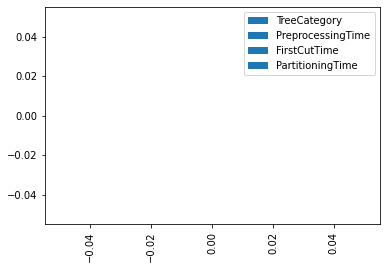

In [5]:
## read runtimes and plot as pie charts
import os
import seaborn as sns
import matplotlib.pyplot as plt
path= "/output"
meanMakespansPerHeuristic = []
#heuristicCombinations = ["LMW-EX-MW","LMW-EX-MD", "LMW-EX-CP",
#                            "LMW-FFT-MW","LMW-FFT-MD", "LMW-FFT-CP",
#                          "LMW-M-MW","LMW-M-MD", "LMW-M-CP", 
#                           "CP-EX-MW","CP-EX-MD", "CP-EX-CP",
#                            "CP-FFT-MW","CP-FFT-MD", "CP-FFT-CP",
#                          "CP-M-MW","CP-M-MD", "CP-M-CP"]


meanNumTrees = []#pandas.DataFrame(columns=['Heuristic', 'TreeCategory', 'Trees'])
meanPreprocessing = []#pandas.DataFrame(columns=['Heuristic', 'TreeCategory', 'PreprocessingTime'])
meanFirstCut = []#pandas.DataFrame(columns=['Heuristic', 'TreeCategory', 'FirstCutTime'])
meanPartitioning = []#pandas.DataFrame(columns=['Heuristic', 'TreeCategory', 'PartitioningTime'])
#meanAssignment = []#pandas.DataFrame(columns=['Heuristic', 'TreeCategory', 'AssignmentTime'])
Heuristics = []
TreeCats = []
cleanFiles(path)

for root, dirs, files in os.walk( os.getcwd()+"/output"):
    for dir in dirs:
        #print(dir)
        for root1, dirs1, files1 in os.walk( os.getcwd()+"/output/"+dir):
            for file in files1:
                if file.endswith((".out")):
                   # print("\t"+file)
                    df = readAllDataOneHeuristicPure(os.getcwd()+"/output/"+dir+"/"+file)
                    #print("df")
                    #print(df)
                    meansMSAndTimes = calculateMeansForOneCategory(df)                    
                    categoryName=file[:-4]                      
                    
                    Heuristics.insert(len(Heuristics), dir)
                    TreeCats.insert(len(categoryName), dir)
                    meanNumTrees.insert(len(meanNumTrees), meansMSAndTimes[1])
                    meanPreprocessing.insert(len(meanPreprocessing), meansMSAndTimes[2])
                    meanFirstCut.insert(len(meanFirstCut), meansMSAndTimes[3])
                    meanPartitioning.insert(len(meanPartitioning), meansMSAndTimes[4])
                    #meanAssignment.insert(len(meanAssignment.index), meansMSAndTimes[5])
              
                   

allTimes = pandas.DataFrame()#columns=['Heuristic', 'TreeCategory', 'PreprocessingTime',\
                                             #       'FirstCutTime','PartitioningTime'])
allTimes['Heuristic'] = Heuristics
allTimes['TreeCategory'] = TreeCats
allTimes['PreprocessingTime'] = meanPreprocessing
allTimes['FirstCutTime'] = meanFirstCut
allTimes['PartitioningTime'] = meanPartitioning
#allTimes['Total'] = meanPartitioning
                
groupedTimes = allTimes.groupby('Heuristic').mean()

timesInMinutes =  pandas.DataFrame()

timesInMinutes['PreprocessingTime'] = groupedTimes['PreprocessingTime'].apply(lambda x: x/600000)
timesInMinutes['FirstCutTime'] = groupedTimes['FirstCutTime'].apply(lambda x: x/600000)
timesInMinutes['PartitioningTime'] = groupedTimes['PartitioningTime'].apply(lambda x: x/600000)

#groupedTimes = groupedTimes.reset_index()
print(timesInMinutes.to_markdown())

#figure, axis = plt.subplots(18, 2)
#for i in range(0, len(groupedTimes), 1):    
#    # declaring data
#   
#    data = groupedTimes.iloc[i][['PreprocessingTime','FirstCutTime','PartitioningTime']]   
#    keys = ['Preprocessing', 'FirstCut', 'Partition+Assignment']
#    
#    palette_color = sns.color_palette('bright')
#
#    # plotting data on chart
#    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
#    #print(i, end =", " )
#    #print(groupedTimes.iloc[i][['Heuristic']][0])
#    axis[i, 0].pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
#    axis[i, 0].set_title(groupedTimes.iloc[i][['Heuristic']][0])


# Combine all the operations and display
#plt.show()

#sns.set(rc = {'figure.figsize':(50,30)})
#sns.set_theme(palette ="bright")
#sns.barplot(x='Heuristic', y='PreprocessingTime', hue ='Heuristic',data = groupedTimes)


groupedTimes.plot(kind='bar', stacked=True)
timesInMinutes.plot(kind='bar', stacked=True)

In [ ]:
## read runtimes and plot as pie charts
import os
import seaborn as sns
import matplotlib.pyplot as plt


def ReadRuntimesFromAllCategoriesCalMeansPerCategoryAndMeanOverAllCategories(path):

    meanMakespansPerHeuristic = []
    meanNumTrees = []
    meanPreprocessing = []
    meanFirstCut = []
    meanPartitioning = []
    Heuristics = []
    TreeCats = []
    cleanFiles(path)

    for root, dirs, files in os.walk(os.getcwd()+path):       
        for dir in dirs:
           #print(dir)
            for root1, dirs1, files1 in os.walk( os.getcwd()+path+"/"+dir):
                #print(files1)
                #print(dirs1)
                #print(root1)
                for file in files1:
                    #print("\t"+file)
                    if file.endswith((".out")):
                        #print("\t"+file)
                        df = readAllDataOneHeuristicPure(os.getcwd()+path+"/"+dir+"/"+file)

                        meansMSAndTimes = calculateMeansForOneCategory(df)                    
                        categoryName=file[:-4]                      

                        Heuristics.insert(len(Heuristics), dir)
                        TreeCats.insert(len(TreeCats), categoryName)
                        meanNumTrees.insert(len(meanNumTrees), meansMSAndTimes[1])
                        meanPreprocessing.insert(len(meanPreprocessing), meansMSAndTimes[2])
                        meanFirstCut.insert(len(meanFirstCut), meansMSAndTimes[3])
                        meanPartitioning.insert(len(meanPartitioning), meansMSAndTimes[4])                



    allTimes = pandas.DataFrame()

    allTimes['Heuristic'] = Heuristics
    allTimes['TreeCategory'] = TreeCats
    allTimes['PreprocessingTime'] = meanPreprocessing
    allTimes['FirstCutTime'] = meanFirstCut
    allTimes['PartitioningTime'] = meanPartitioning


    groupedTimes = allTimes.groupby('Heuristic').mean()

    timesInMinutes =  pandas.DataFrame()

    timesInMinutes['PreprocessingTime'] = groupedTimes['PreprocessingTime'].apply(lambda x: x/60)
    timesInMinutes['FirstCutTime'] = groupedTimes['FirstCutTime'].apply(lambda x: x/60)
    timesInMinutes['PartitioningTime'] = groupedTimes['PartitioningTime'].apply(lambda x: x/60)
    return (allTimes, groupedTimes, timesInMinutes)

   


#figure, axis = plt.subplots(18, 2)
#for i in range(0, len(groupedTimes), 1):    
#    # declaring data
#   
#    data = groupedTimes.iloc[i][['PreprocessingTime','FirstCutTime','PartitioningTime']]   
#    keys = ['Preprocessing', 'FirstCut', 'Partition+Assignment']
#    
#    palette_color = sns.color_palette('bright')
#
#    # plotting data on chart
#    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
#    #print(i, end =", " )
#    #print(groupedTimes.iloc[i][['Heuristic']][0])
#    axis[i, 0].pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
#    axis[i, 0].set_title(groupedTimes.iloc[i][['Heuristic']][0])


# Combine all the operations and display
#plt.show()

#sns.set(rc = {'figure.figsize':(50,30)})
#sns.set_theme(palette ="bright")
#sns.barplot(x='Heuristic', y='PreprocessingTime', hue ='Heuristic',data = groupedTimes)

path= "/output"
allTimes, groupedTimes, timesInMinutes = ReadRuntimesAndPlotBars(path)
print(timesInMinutes.to_markdown())
groupedTimes.plot(kind='bar', stacked=True)
timesInMinutes.plot(kind='bar', stacked=True)


In [ ]:
path= "/output-29-07"
allTimes,groupedTimes, timesInMinutes = ReadRuntimesFromAllCategoriesCalMeansPerCategoryAndMeanOverAllCategories(path)
#groupedTimes.drop(['A'], axis=1)

groupedTimes.drop(groupedTimes.tail(1).index,
        inplace = True)
print(groupedTimes)
groupedTimes.plot(kind='bar', stacked=True)
#timesInMinutes.plot(kind='bar', stacked=True)

In [ ]:
path= "/output"
allTimes,groupedTimes, timesInMinutes = ReadRuntimesFromAllCategoriesCalMeansPerCategoryAndMeanOverAllCategories(path)

allTimes['PreprocessingTime'] = allTimes['PreprocessingTime'].apply(lambda x: x/60000000)
print(allTimes)
del allTimes['FirstCutTime']
del allTimes['PartitioningTime']
del allTimes['Heuristic']
allTimes.plot(kind='bar')

In [ ]:
data={'TreeCategory':['3ch','20ch'],'MinMem Time':[0,0], "MinMem Root Requirement": [0,0], "Half Time": [-706.414615563176, \
        -534.357433588953], "Half Root Requirement": [52.8386325668573, 90.3930707263381],\
     "Greedy Time": [-2983.91059286843, -4656.27975478794], "Greedy Root Requirement":[56.7478685829985, 94.7169754684557]}
df=pandas.DataFrame(data)


avgcol = df.mean(axis=0)

df.loc[len(df.index)] =avgcol
#print(df)

df1 = df[2:]
print(df1)
dfTime = df1.filter(items=['MinMem Time','Half Time', 'Greedy Time'])

#dfTime.columns =['Heuristics', 'Decrease in Runtime in comaprison to full MinMem']
dfTime.plot.bar()

dfMS = df1.filter(items=['MinMem Root Requirement','Half Root Requirement', 'Greedy Root Requirement'])

#dfTime.columns =['Heuristics', 'Decrease in Runtime in comaprison to full MinMem']
dfMS.plot.bar()



In [ ]:
#data={"num":, [1,, 2,3,4,5,6,7,, 8,9],, "a":, [],, "b"

#}

import matplotlib.pyplot as plt

data = {# "name": ["a", "b", "c"], 
"1": [ 29.910014232884, 24.950774396381, 42.270836317419],
"2": [ 15.44857868588, 32.907458350589, 86.76406526486],
"3": [ 17.060102993211, 40.042124451257, 93.701799688934],
"4": [ -4.9733079522547, -12.1327666622206, 5.57994946087801],
"5": [ 0, 2.57687999771301, 23.089894858029],
"6": [ 26.131805712071, 47.902082566953, 111.615342857319],
"7": [ 21.173001123535, 37.930515963078, 90.407677956226],
"8": [ 0, 35.978155446789, 98.677941009851],
"9": [ 8.04780860171901, 29.44182593766, 82.736338958762]}

df=pandas.DataFrame(data)

df1_transposed = df.T
print(df.iloc[[0]])

fig, ax = plt.subplots()
#fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.boxplot(df.iloc[[0]])  
plt.xticks([1, 2, 3, 4,5,6,7,8,9], ["sparse matrix trees", "bla", "bla", "bla","bla","bla","bla","bla","bla"],\
           rotation=40)

# show plot
plt.show()


             FirstCutTime  PartitioningTime  AssignmentTime  ChooseNodeTime  \
Heuristic                                                                     
CP-FFT-CP      370.637037          4.896296        0.210655        0.232632   
CP-FFT-MD      356.266667          4.985185        0.209651        0.232625   
CP-FFT-MW      355.800000          4.896296        0.210481        0.232812   
CP-FFTM-CP     124.133333        512.066667       87.541779        0.209321   
CP-FFTM-MD     124.888889        512.822222       87.613666        0.205213   
CP-FFTM-MW     124.288889        518.422222       87.722286        0.204473   
CP-M-CP        355.148148         36.133333        6.849182        0.716472   
CP-M-MD        354.940741         36.548148        6.867603        0.713748   
CP-M-MW        355.088889         35.948148        6.845236        0.717290   
LMW-FFT-CP     357.177778          3.185185        0.161501        0.000000   
LMW-FFT-MD     355.525926          3.207407        0

<AxesSubplot:xlabel='Heuristic'>

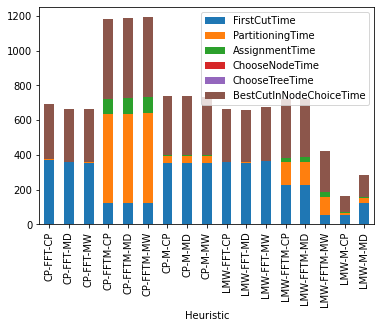

In [10]:
def calculateMeansForOneCategory(dfWorse):
    #print(dfWorse)
    meanMS = dfWorse['makespan'].mean()
    meanTrees = dfWorse['#trees'].mean() 
    meantime1cut = dfWorse['time1cut'].mean()
    meantimepartition = dfWorse['timepartition'].mean()
    meantimeassign = dfWorse['timeassign'].mean()
    meantimeChooseTree = dfWorse['timeChooseTree'].mean()
    meantimeChooseNode = dfWorse['timeChooseNode'].mean()
    meantimeBestCutInNodeChoice = dfWorse['timeBestCutInNodeChoice'].mean()
    
    means= [meanMS, meanTrees, meantime1cut, meantimepartition, meantimeassign, meantimeChooseTree,\
           meantimeChooseNode, meantimeBestCutInNodeChoice]
   # print("means here")
    #print(means)
    return means
def readAllDataOneHeuristicMoreTimes(path):
    #print(path)
    
    dfWorse = pandas.read_table(path, delim_whitespace=True, names=('treeName', 'makespan', '#trees', 
                                                               'time1cut', 'timepartition', 
                                                                'timeassign', 'timeChooseTree', 'timeChooseNode',\
                                                                    'timeBestCutInNodeChoice')
                       ,dtype={'treeName': str, 'makespan': np.float64, '#trees': np.float64, 
                                 'time1cut': np.float64,'timepartition': np.float64,  'timeassign': np.float64,\
                               'timeChooseTree': np.float64,'timeChooseNode': np.float64,\
                               'timeBestCutInNodeChoice': np.float64})
    
    #dfWorse = dfWorse[pandas.notna(dfWorse['makespan'])]   
  
    return dfWorse
  

def ReadRuntimesWithMoreTimes(path):

    meanMakespansPerHeuristic = []
    meanNumTrees = []
    meanFirstCut = []
    meanAssignment =[]
    meanChooseNode =[]
    meanChooseTree =[]
    meanBestCutInNodeChoice = []
    meanPartitioning = []
    Heuristics = []
    TreeCats = []
    cleanFiles(path)

    for root, dirs, files in os.walk(os.getcwd()+path):       
        for dir in dirs:         
            for root1, dirs1, files1 in os.walk( os.getcwd()+path+"/"+dir):               
                for file in files1:                   
                    if file.endswith((".out")):    
                       # print(file)
                        df = readAllDataOneHeuristicMoreTimes(os.getcwd()+path+"/"+dir+"/"+file)

                        meansMSAndTimes = calculateMeansForOneCategory(df)  
                        categoryName=file[:-4]                      
                      # print(meansMSAndTimes)
                        #print(meansMSAndTimes[0])
                        Heuristics.insert(len(Heuristics), dir)
                        TreeCats.insert(len(TreeCats), categoryName)
                        meanNumTrees.insert(len(meanNumTrees), meansMSAndTimes[1])                       
                        meanFirstCut.insert(len(meanFirstCut), meansMSAndTimes[2])
                        meanPartitioning.insert(len(meanPartitioning), meansMSAndTimes[3])
                        meanAssignment.insert(len(meanAssignment), meansMSAndTimes[4])     
                        meanChooseNode.insert(len(meanChooseNode), meansMSAndTimes[5]) 
                        meanChooseTree.insert(len(meanChooseTree), meansMSAndTimes[6])     
                        meanBestCutInNodeChoice.insert(len(meanBestCutInNodeChoice), meansMSAndTimes[7])



    allTimes = pandas.DataFrame()

    allTimes['Heuristic'] = Heuristics
    allTimes['TreeCategory'] = TreeCats    
    allTimes['FirstCutTime'] = meanFirstCut
    allTimes['PartitioningTime'] = meanPartitioning
    allTimes['AssignmentTime'] = meanAssignment
    allTimes['ChooseNodeTime'] = meanChooseNode
    allTimes['ChooseTreeTime'] = meanChooseTree
    allTimes['BestCutInNodeChoiceTime'] = meanBestCutInNodeChoice
    allTimes['BestCutInNodeChoiceTime']  =  allTimes['BestCutInNodeChoiceTime'].apply(lambda x: x*0.5)


    groupedTimes = allTimes.groupby('Heuristic').mean()

    timesInMinutes =  pandas.DataFrame()
   
    return (allTimes, groupedTimes, timesInMinutes)


path= "/output-17-08"
allTimes,groupedTimes, timesInMinutes = ReadRuntimesWithMoreTimes(path)

groupedTimes.drop(groupedTimes.tail(1).index,
        inplace = True)
print(groupedTimes)
groupedTimes.plot(kind='bar', stacked=True)
